<a href="https://colab.research.google.com/github/Abhi-gola/Fruit-classifier/blob/main/Facial_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhigola","key":"ca6fc2f8cf690e8b1900886e54b83af9"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c facial-keypoints-detection

 31% 5.00M/16.0M [00:00<00:00, 33.2MB/s]
100% 16.0M/16.0M [00:00<00:00, 63.3MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 193MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 118MB/s]
 68% 41.0M/60.1M [00:00<00:00, 30.3MB/s]
100% 60.1M/60.1M [00:01<00:00, 61.5MB/s]


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import ReLU, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
train_data = pd.read_csv('/content/training.zip')
test_data = pd.read_csv('/content/test.zip')
idlookup_data = pd.read_csv('/content/IdLookupTable.csv')

In [ ]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
clean_data = train_data.dropna()
print('shape of clean data: ', clean_data.shape)
unclean_data = train_data.fillna(method = 'ffill')
print('shape of unclean data: ', unclean_data.shape)

shape of clean data:  (2140, 31)
shape of unclean data:  (7049, 31)


In [ ]:
horizontal_flip = True 
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True
blurred_augmentation = True

include_unclean_data = True
sample_image_index = 20

rotation_angles = [12]
pixel_shifts = [12]

NUM_EPOCHS = 50
BATCH_SIZE = 64

In [ ]:
def plot_image(image, keypoint, axis):
  image = image.reshape(96,96) #if in case image is not in this shape
  axis.imshow(image, cmap='gray')
  axis.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=15)

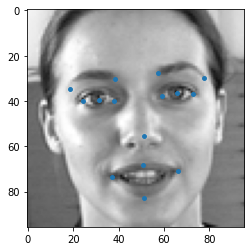

In [ ]:
def load_images(image_data):
  images = []
  for index, series in image_data.iterrows():
    image = np.array(series['Image'].split(' '), dtype=int)
    image = np.reshape(image, (96,96,1))
    images.append(image)
  images = np.array(images)/255.0
  return images

def load_keypoints(keypoint_data):
  keypoint_data = keypoint_data.drop('Image', axis=1)
  keypoint_features = []
  for index, series_keypoints in keypoint_data.iterrows():
    keypoint_features.append(series_keypoints)
  keypoint_features = np.array(keypoint_features, dtype='float')
  return keypoint_features

clean_train_images = load_images(clean_data)
clean_train_keypoints = load_keypoints(clean_data)
test_images = load_images(test_data)

train_images = clean_train_images
train_keypoints = clean_train_keypoints #we further need clean_train_images/keypoints
# that's why we didn't directly defined train_images
fig, axis = plt.subplots()
plot_image(train_images[sample_image_index], train_keypoints[sample_image_index], axis)

if include_unclean_data:
  unclean_train_images = load_images(unclean_data)
  unclean_train_keypoints = load_keypoints(unclean_data)
  # combining with train_keypoints and train_images
  train_images = np.concatenate((train_images, unclean_train_images))
  train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

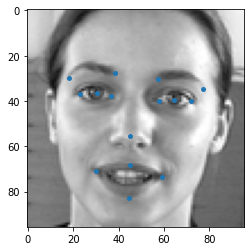

In [ ]:
def horizontalflip(images, keypoints):
  flipped_keypoints = []
  flipped_images = np.flip(images, axis=2)
  for index, series in enumerate(keypoints):
    flipped_keypoints.append([96.0-coor if index%2==0 else coor for index, coor in enumerate(series)])
  return flipped_images, flipped_keypoints
if horizontal_flip:
  flipped_train_images, flipped_train_keypoints = horizontalflip(clean_train_images, clean_train_keypoints)
  train_images = np.concatenate((train_images, flipped_train_images))
  train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
  fig, axis = plt.subplots()
  plot_image(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis)

Increased brightness Image 
Decreased brightness Image


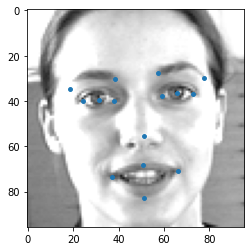

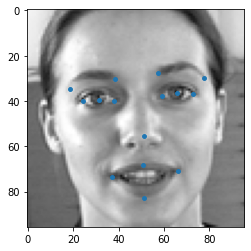

In [ ]:
def change_brightness(images, keypoints):
  new_brightness_images = []
  inc_brightness_images = np.clip(images*1.3, 0.0, 1.0)
  dec_brightness_images = np.clip(images*0.7, 0.0, 1.0)
  new_brightness_images.extend(inc_brightness_images)
  new_brightness_images.extend(dec_brightness_images)
  return new_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
  new_brightness_train_images, new_brightness_train_keypoints = change_brightness(clean_train_images, clean_train_keypoints)
  train_images = np.concatenate((train_images, new_brightness_train_images))
  train_keypoints = np.concatenate((train_keypoints, new_brightness_train_keypoints))
  fig, axis = plt.subplots()

  print("Increased brightness Image ")
  plot_image(new_brightness_train_images[sample_image_index], new_brightness_train_keypoints[sample_image_index], axis)

  fig, axis = plt.subplots()
  print("Decreased brightness Image")
  plot_image(new_brightness_train_images[len(new_brightness_train_images)//2+sample_image_index], new_brightness_train_keypoints[len(new_brightness_train_images)//2+sample_image_index], axis)

In [ ]:
clean_train_images.shape[0]

2140

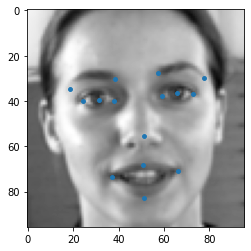

In [ ]:
from scipy.ndimage.filters import gaussian_filter
def blurr_images(images, keypoints):
  blurred_images = []
  for i in range(clean_train_images.shape[0]):
    blurred = gaussian_filter(clean_train_images[20], sigma=0.6)
    blurred_images.append(blurred)
  return blurred_images, keypoints

if blurred_augmentation:
  blurred_train_images, blurred_train_keypoints =blurr_images(clean_train_images, clean_train_keypoints)
  
  train_images = np.concatenate((train_images, blurred_train_images))
  train_keypoints = np.concatenate((train_keypoints, blurred_train_keypoints))
  fig, axis = plt.subplots()
  plot_image(blurred_train_images[sample_image_index], blurred_train_keypoints[sample_image_index], axis)

In [ ]:
train_images.shape

(17749, 96, 96, 1)

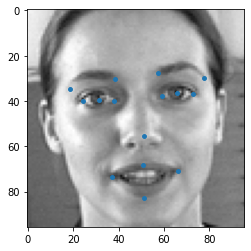

In [ ]:
def add_noise(images):
  noisy_images = []
  for image in images:
    noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))
    noisy_images.append(noisy_image.reshape(96,96,1))
  return noisy_images

if random_noise_augmentation:
  noisy_train_images = add_noise(clean_train_images)
  train_images = np.concatenate((train_images, noisy_train_images))
  train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
  fig, axis = plt.subplots()
  plot_image(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis)

In [ ]:
train_images.shape

(19889, 96, 96, 1)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(96,96,1)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(96,96,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                      

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'acc'])

# Train the model
history = model.fit(train_images, train_keypoints, epochs=70, batch_size=BATCH_SIZE, validation_split=0.05, callbacks=[checkpointer])

Epoch 1/70
296/296 [==============================] - ETA: 0s - loss: 49.7777 - mse: 49.7777 - acc: 0.5050
Epoch 00001: val_mse improved from inf to 21.49664, saving model to best_model.hdf5
296/296 [==============================] - 42s 138ms/step - loss: 49.7777 - mse: 49.7777 - acc: 0.5050 - val_loss: 21.4966 - val_mse: 21.4966 - val_acc: 0.5206
Epoch 2/70
296/296 [==============================] - ETA: 0s - loss: 37.7170 - mse: 37.7170 - acc: 0.5548
Epoch 00002: val_mse did not improve from 21.49664
296/296 [==============================] - 40s 135ms/step - loss: 37.7170 - mse: 37.7170 - acc: 0.5548 - val_loss: 46.7726 - val_mse: 46.7726 - val_acc: 0.5357
Epoch 3/70
296/296 [==============================] - ETA: 0s - loss: 35.0901 - mse: 35.0901 - acc: 0.5856
Epoch 00003: val_mse improved from 21.49664 to 17.97218, saving model to best_model.hdf5
296/296 [==============================] - 40s 137ms/step - loss: 35.0901 - mse: 35.0901 - acc: 0.5856 - val_loss: 17.9722 - val_mse: 1

In [ ]:
model = load_model('best_model.hdf5')
test_preds = model.predict(test_images)

In [ ]:
feature_names = list(idlookup_data['FeatureName'])
image_ids = list(idlookup_data['ImageId']-1)
row_ids = list(idlookup_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)